In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from joblib import Parallel, delayed
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_splint

OSError: dlopen(/usr/local/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /usr/local/lib/python3.9/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [7]:

#data = reduce_mem_usage(data)

data = pd.read_parquet('/Users/donghaoling/Downloads/train_low_mem.parquet')
data

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,1219_3768,1219,3768,0.033600,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,1219_3769,1219,3769,-0.223264,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,1219_3770,1219,3770,-0.559415,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,1219_3772,1219,3772,0.009599,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


In [8]:
data.describe()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
count,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,...,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06,3.141410e+06
mean,6.654862e+02,1.885265e+03,-2.109231e-02,1.637028e-03,-1.257750e-02,8.514524e-03,-2.003680e-02,-5.416394e-03,-3.034038e-03,1.934293e-03,...,1.257388e-02,8.997587e-04,-6.509002e-03,2.850204e-03,-4.732862e-03,-2.773726e-02,-1.517807e-03,-7.058299e-03,-4.216855e-03,-4.319444e-03
std,3.560434e+02,1.083616e+03,9.197057e-01,1.081097e+00,1.032447e+00,1.031786e+00,9.630771e-01,9.943870e-01,1.105940e+00,1.068882e+00,...,1.085783e+00,1.114992e+00,1.071597e+00,1.103297e+00,1.145119e+00,9.608897e-01,1.141631e+00,1.109445e+00,1.052312e+00,1.010046e+00
min,0.000000e+00,0.000000e+00,-9.419646e+00,-1.765789e+01,-6.579473e+00,-8.644268e+00,-1.800427e+01,-4.000015e+00,-8.833704e+00,-6.384251e+00,...,-9.271487e+00,-6.359966e+00,-8.183732e+00,-2.399478e+01,-1.497270e+01,-9.348986e+00,-7.366648e+00,-7.579406e+00,-6.707284e+00,-1.028264e+01
25%,3.530000e+02,9.520000e+02,-5.004572e-01,-4.071441e-01,-6.813878e-01,-6.530838e-01,-4.496046e-01,-3.532303e-01,-7.070855e-01,-7.911198e-01,...,-6.037326e-01,-8.355157e-01,-6.981400e-01,-1.377131e-01,-9.397985e-01,-5.147926e-01,-9.573807e-01,-7.239380e-01,-8.165390e-01,-5.080143e-01
50%,7.040000e+02,1.882000e+03,-9.717009e-02,2.431158e-01,-4.867587e-02,4.350941e-02,-2.639937e-01,-1.908876e-01,-2.144796e-02,1.437945e-02,...,6.086323e-02,-2.023181e-01,-1.910102e-01,2.164071e-01,2.087202e-01,-2.907780e-01,6.955573e-03,-1.650222e-01,2.300689e-02,-2.824031e-01
75%,9.750000e+02,2.830000e+03,3.572908e-01,6.649507e-01,6.086557e-01,6.587324e-01,7.763371e-02,2.784694e-02,6.835684e-01,8.008306e-01,...,6.882384e-01,9.035954e-01,4.841421e-01,5.088849e-01,8.616266e-01,1.275946e-01,9.503851e-01,6.098197e-01,7.984827e-01,1.411301e-01
max,1.219000e+03,3.773000e+03,1.203861e+01,7.845261e+00,8.707207e+00,8.009340e+00,4.706333e+01,7.662866e+01,7.646200e+00,6.778142e+00,...,9.298274e+00,9.725060e+00,2.231185e+01,6.587691e+00,6.978151e+00,6.140367e+01,7.679950e+00,1.241804e+01,7.003982e+00,4.337021e+01


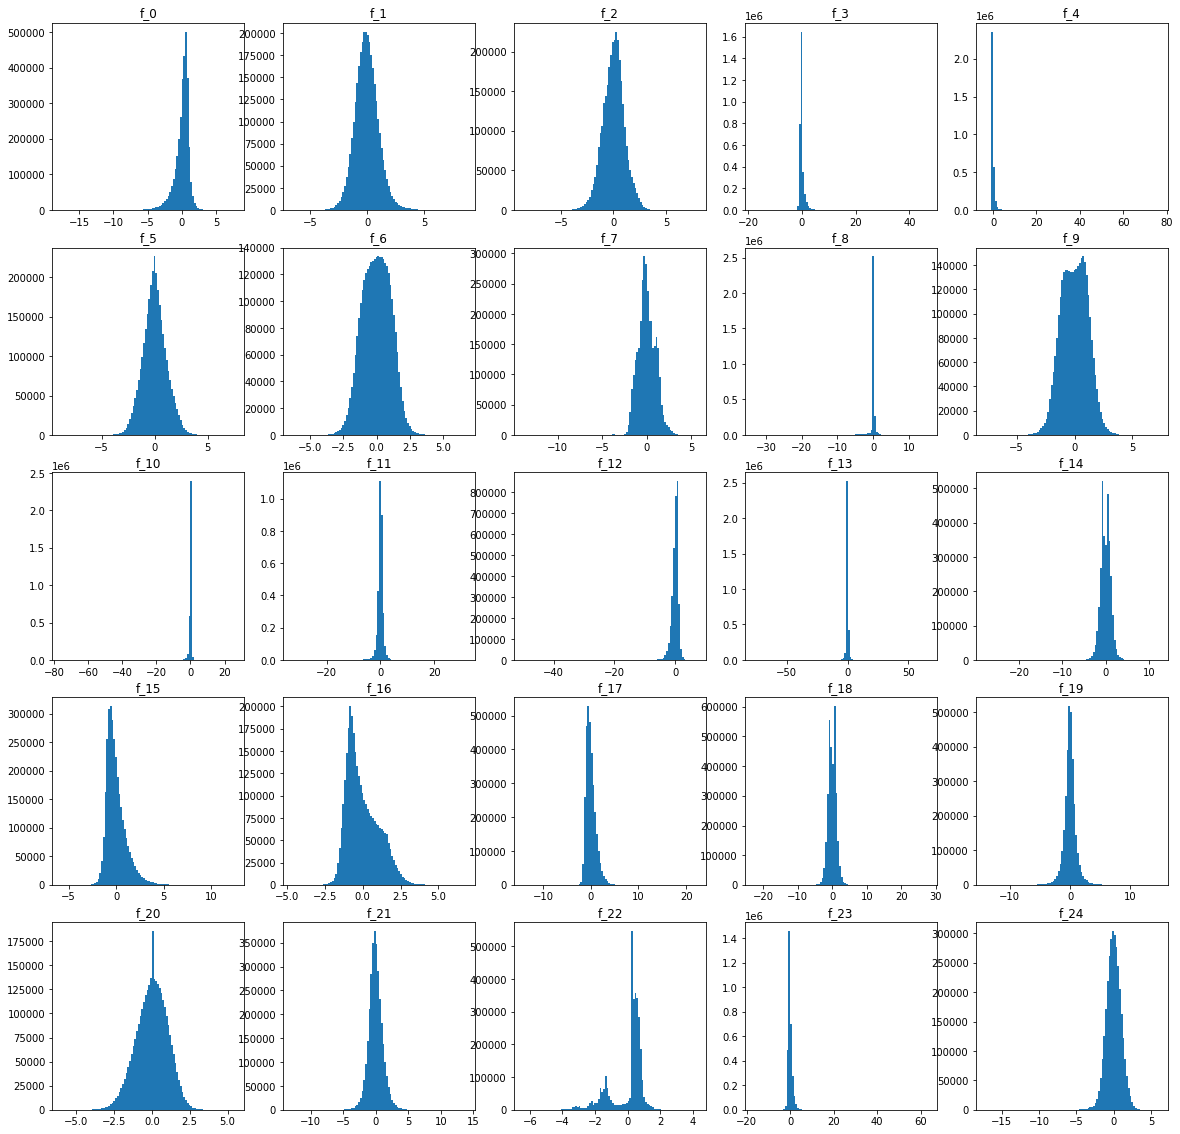

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20))
for i in range(25) :
    plt.subplot(5, 5, i+1)
    plt.hist(data[f"f_{i}"], bins=100)
    plt.title(f"f_{i}")
plt.show()

In [21]:
outlier_list = []
outlier_col = []
z = data.drop(['row_id', 'time_id', 'target', 'investment_id'],axis = 1)
feature_cols = z.columns.unique()

for col in feature_cols :
    temp_df = z[(z[col] > z[col].mean() + z[col].std() * 50) |
                       (z[col] < z[col].mean() - z[col].std() * 50) ]
    temp2_df = z[(z[col] > z[col].mean() + z[col].std() * 25) |
                        (z[col] < z[col].mean() - z[col].std() * 25) ]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) < 20  :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
print(len(outlier_col), len(outlier_list))


f_4 138
f_8 12
f_10 33
f_11 10
f_12 13
f_13 7
f_23 6
f_37 10
f_38 5
f_40 18
f_41 1
f_44 2
f_49 12
f_54 2
f_59 7
f_62 9
f_64 5
f_74 72
f_78 43
f_83 9
f_84 12
f_89 19
f_95 12
f_101 4
f_102 2
f_104 1
f_110 8
f_115 79
f_117 50
f_118 7
f_124 23
f_125 1
f_127 79
f_128 1
f_129 12
f_131 46
f_136 1
f_137 16
f_145 10
f_149 2
f_151 34
f_153 1
f_155 21
f_159 1
f_162 6
f_165 1
f_172 41
f_173 3
f_174 3
f_175 32
f_179 13
f_183 75
f_184 15
f_188 1
f_193 24
f_196 2
f_197 1
f_200 118
f_202 19
f_214 1
f_215 1
f_219 1
f_224 13
f_228 5
f_233 7
f_235 6
f_236 10
f_245 3
f_249 1
f_250 9
f_251 1
f_262 4
f_265 11
f_269 16
f_271 15
f_275 1
f_277 1
f_278 2
f_280 17
f_286 9
f_289 67
f_295 1
82 931


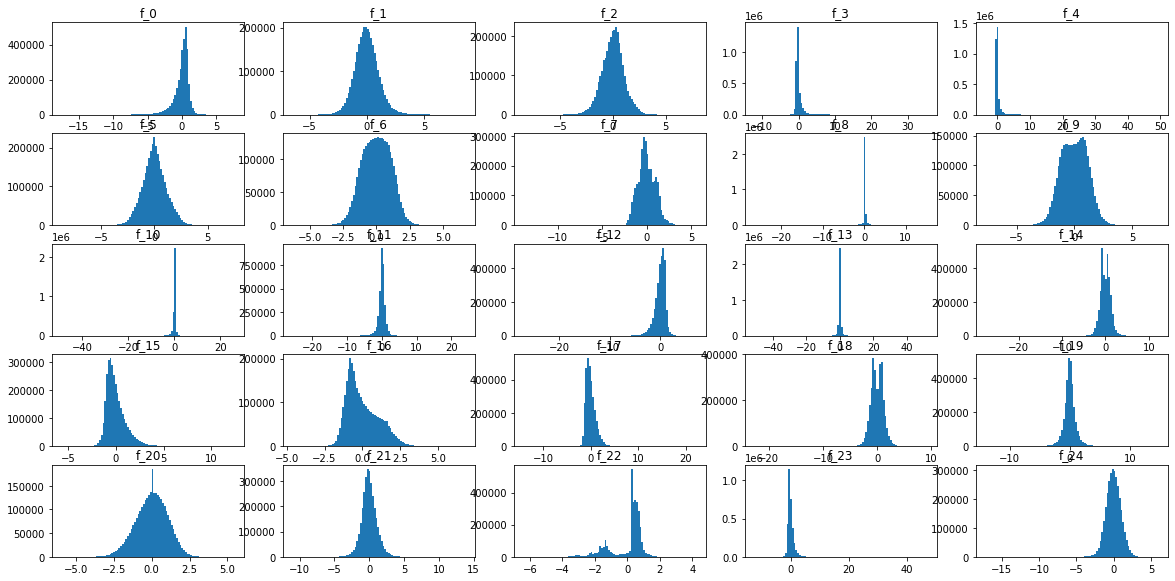

In [22]:
z.drop(z.index[outlier_list], inplace = True)

plt.figure(figsize=(20,20))
for i in range(25) :
    plt.subplot(10, 5, i+1)
    plt.hist(z[f"f_{i}"], bins=100)
    plt.title(f"f_{i}")
plt.show()

In [25]:
#归一化Z z-score
def Normalize(raw_list):
    np_data=np.array(raw_list)
    length=len(raw_list)
    #列均值
    means=np.mean(np_data,axis=0)
    #列标准差
    sigmas=np.std(np_data,axis=0)
    #z-score转化成矩阵运算
    mean_matrix=np.tile(means,(length,1))
    sigma_matrix=np.tile(sigmas,(length,1))
    np_data=(np_data-mean_matrix)/sigma_matrix

    return np_data

Normalize(z)

In [7]:
time_id = data['time_id']
row_id = data['row_id']
y = data['target']
X = data.drop(['row_id', 'time_id', 'target'], axis=1)
z = data.drop(['row_id', 'time_id', 'target', 'investment_id'],axis = 1)
z

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,0.114807,-2.013672,...,0.365967,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533
1,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,0.114807,-0.219238,...,-0.154175,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506
2,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,0.114807,-1.035156,...,-0.138062,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652
3,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,0.114807,-1.176758,...,0.382080,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438
4,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,0.114807,-0.005859,...,-0.170410,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093506,-0.720215,-0.345459,-0.438721,-0.166992,-0.437256,1.475586,1.284180,0.056427,-1.433594,...,-0.285889,-1.232422,-0.660645,0.875488,0.421631,-0.427979,-0.075562,-0.533203,-0.193726,-0.581543
3141406,-1.344727,-0.199951,-0.107727,-0.454590,-0.221924,-0.141113,-1.498047,1.374023,0.056427,-1.211914,...,0.184570,-1.232422,-0.670410,0.875488,0.421631,-0.729980,-1.514648,0.013145,-0.890137,-0.589844
3141407,0.979492,-1.110352,1.006836,-0.467285,-0.159546,1.355469,0.150757,-0.088928,0.056427,0.996582,...,-0.756348,-1.232422,0.820801,-1.142578,0.421631,-0.363281,1.363281,-0.079102,-1.580078,-0.297607
3141408,-2.564453,0.320312,0.076599,1.379883,-0.155396,-0.688965,0.381104,-1.325195,0.056427,-1.111328,...,-0.756348,-1.232422,0.133057,-1.142578,0.421631,-0.375244,-1.514648,-0.973633,0.608887,-0.372070


In [7]:
data['investment_id'] = data['investment_id'].astype('category')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [15]:
# # 参数
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',  # 设置提升类型
#     'objective': 'regression',  # 目标函数
#     'metric': {'auc'},  # 评估函数
#     'max_bin': 255,  # 大会有更准的效果,更慢的速度
#     'min_data_in_leaf': 91,
#     'num_iterations': 500,
#     'max_depth': 4,  # 指定树的最大深度 [3, 5, 6, 7, 9, 12, 15, 17, 25]
#     'num_leaves': 10,  # 叶子节点数
#     'learning_rate': 0.1,  # 学习速率 [0.01, 0.015, 0.025, 0.05, 0.1]
#     'feature_fraction': 1.0,  # 建树的特征选择比例 [0.6, 0.7, 0.8, 0.9, 1]
#     'bagging_fraction': 0.6,  # 建树的样本采样比例 [0.6, 0.7, 0.8, 0.9, 1]
#     # 'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
#     'min_sum_hessian_in_leaf': 3.0,  # 防止过拟合
#     'verbose': 1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
# }
params = {
        'learning_rate':0.1,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': -1,
        'n_jobs': -1, 
        'seed': 21,
        'lambda_l1': 1.1895057699067542, 
        'lambda_l2': 1.9079686837880768e-08, 
        'num_leaves': 112, 
        'subsample':None,
        'feature_fraction': 0.6259927292757151, 
        'bagging_fraction': 0.9782210574588895, 
        'bagging_freq': 1, 
        'n_estimators': 306, 
        'max_depth': 12, 
        'max_bin': 255, 
        'min_data_in_leaf': 366,
        'colsample_bytree': None,
        'subsample_freq': None,
        'min_child_samples': None,
        'reg_lambda': None,
        'reg_alpha': None,
    }

In [16]:
gbm = lgb.train(params, lgb_train, num_boost_round=500, valid_sets=[lgb_eval],
                verbose_eval=100, early_stopping_rounds=300)
# 模型保存
gbm.save_model('model.txt')

/Users/wumx/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 300 rounds
[100]	valid_0's rmse: 0.906656
[200]	valid_0's rmse: 0.903319
[300]	valid_0's rmse: 0.900994
Did not meet early stopping. Best iteration is:
[306]	valid_0's rmse: 0.900828


In [17]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.9008282186381865
